In [30]:
import os, sys
sys.path.insert(0, os.path.abspath("../src"))
from sentinelml.features import build_feature_table
from sentinelml.model import load_model, anomaly_scores

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load raw logs
RAW_PATH = "../data/raw/security_logs.jsonl"
df = pd.read_json(RAW_PATH, lines=True)

# Reuse your project feature builder
import sys
sys.path.append("..")  # so notebook can import src package in a pinch

from src.sentinelml.features import build_feature_table

X, meta = build_feature_table(df)

meta.head(), X.head()


(    user_id                    window  injected_anoms anomaly_type
 0  user_000 2026-01-22 02:40:00+00:00           False          NaN
 1  user_000 2026-01-22 03:45:00+00:00           False          NaN
 2  user_000 2026-01-22 13:00:00+00:00           False          NaN
 3  user_000 2026-01-22 20:30:00+00:00           False          NaN
 4  user_000 2026-01-23 04:45:00+00:00           False          NaN,
    event_count  login_count  fail_login_count  unique_resources  \
 0            1            0                 0                 1   
 1            1            0                 0                 1   
 2            1            0                 0                 1   
 3            1            1                 1                 1   
 4            1            1                 0                 1   
 
    unique_event_types  total_bytes  max_bytes  mean_bytes  std_bytes  \
 0                   1         1501       1501      1501.0        0.0   
 1                   1         3006

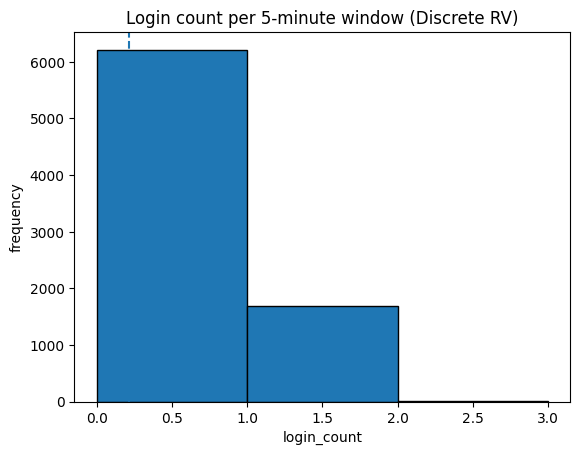

np.float64(0.21431280819319762)

In [31]:
# Reconstruct the feature table with the keys (user_id, window) for plotting
# We can rebuild quickly by re-aggregating, but easiest is to recompute with keys:
d = df.copy()
d["timestamp"] = pd.to_datetime(d["timestamp"], utc=True)
d["window"] = d["timestamp"].dt.floor("5min")

agg = d.groupby(["user_id","window"], as_index=False).agg(
    login_count=("event_type", lambda x: int((x=="login").sum()))
)

vals = agg["login_count"].values
lam_hat = vals.mean()  # empirical mean as Poisson baseline

plt.figure()
plt.hist(vals, bins=range(0, int(vals.max())+2), edgecolor="black")
plt.title("Login count per 5-minute window (Discrete RV)")
plt.xlabel("login_count")
plt.ylabel("frequency")
plt.axvline(lam_hat, linestyle="--")
plt.savefig("../reports/login_count_histogram.png")
plt.show()

lam_hat


### Login Count Histogram
This plot shows the distribution of login events per user in each 5-minute window. The x-axis is the number of logins, and the y-axis is the frequency of those counts. The dashed line marks the average login count ($\hat{\lambda}$), which is used as a Poisson baseline for normal activity.

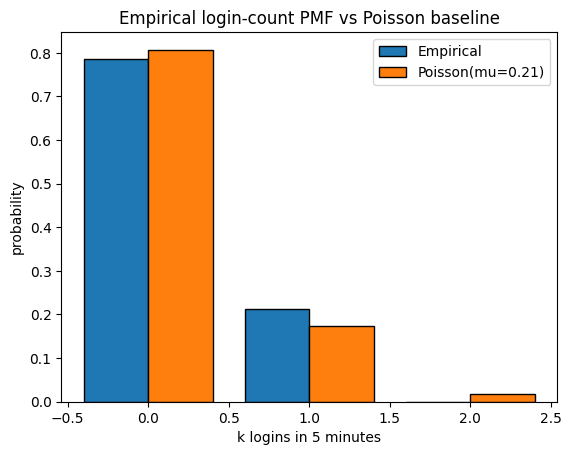

In [32]:
k_max = min(int(vals.max()), 25)
ks = np.arange(0, k_max+1)

# Empirical probability mass
emp_counts = np.bincount(vals.astype(int))
emp_p = emp_counts[:k_max+1] / emp_counts.sum()

# Poisson pmf using lambda_hat
pois_p = stats.poisson.pmf(ks, mu=lam_hat)

plt.figure()
plt.bar(ks - 0.2, emp_p, width=0.4, edgecolor="black", label="Empirical")
plt.bar(ks + 0.2, pois_p, width=0.4, edgecolor="black", label=f"Poisson(mu={lam_hat:.2f})")
plt.title("Empirical login-count PMF vs Poisson baseline")
plt.xlabel("k logins in 5 minutes")
plt.ylabel("probability")
plt.legend()
plt.savefig("../reports/empirical_vs_poisson_pmf.png")
plt.show()


### Empirical vs Poisson PMF
This bar chart compares the empirical probability mass function (PMF) of login counts to the theoretical Poisson PMF using the observed mean. The left bars show the actual observed probabilities for each login count; the right bars show the expected probabilities if logins followed a Poisson process. This helps you see if login activity matches a typical random process or if there are deviations.

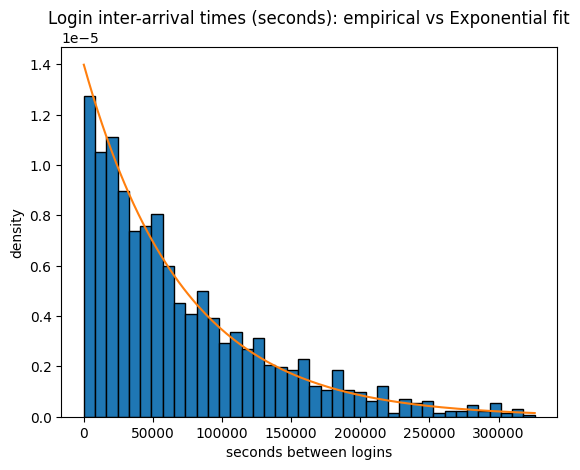

(np.float64(71485.67755809637), np.float64(1.3988816139950559e-05))

In [33]:
logins = df[df["event_type"]=="login"].copy()
logins["timestamp"] = pd.to_datetime(logins["timestamp"], utc=True)
logins = logins.sort_values(["user_id","timestamp"])

# Inter-arrival times in seconds per user
logins["delta_s"] = logins.groupby("user_id")["timestamp"].diff().dt.total_seconds()
gaps = logins["delta_s"].dropna()
gaps = gaps[(gaps > 0) & (gaps < gaps.quantile(0.99))]  # trim extreme tail for readable plot

# Fit exponential: mean gap = 1/rate
mean_gap = gaps.mean()
rate = 1.0 / mean_gap

x = np.linspace(0, gaps.max(), 200)
exp_pdf = stats.expon.pdf(x, scale=mean_gap)

plt.figure()
plt.hist(gaps, bins=40, density=True, edgecolor="black")
plt.plot(x, exp_pdf)  # no custom colors per your environment defaults
plt.title("Login inter-arrival times (seconds): empirical vs Exponential fit")
plt.xlabel("seconds between logins")
plt.ylabel("density")
plt.savefig("../reports/login_interarrival_times.png")
plt.show()

mean_gap, rate


### Login Inter-arrival Times
This histogram shows the distribution of time gaps (in seconds) between consecutive logins for each user. The overlaid curve is the exponential probability density function (PDF) fitted to the mean gap. This visualization checks if login times are consistent with a memoryless (random) process, as expected in normal behavior.

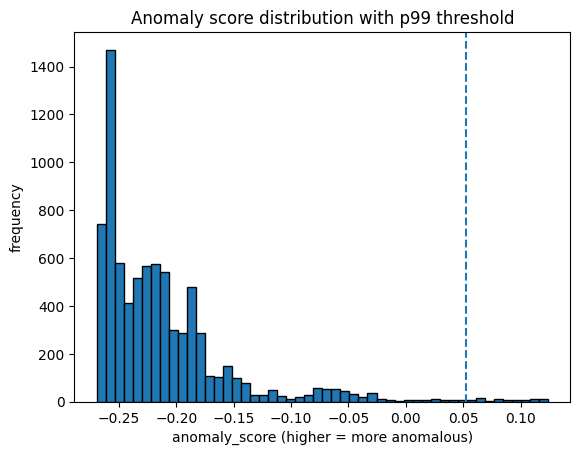

np.float64(0.05222701543265502)

In [35]:
from src.sentinelml.model import load_model, anomaly_scores

# Build features
X, meta = build_feature_table(df)

# Load model
model = load_model("../models/isoforest.joblib")

# Align feature columns exactly to training time
expected = model.named_steps["scaler"].feature_names_in_
X = X.reindex(columns=expected, fill_value=0.0)

scores = anomaly_scores(model, X)

p = 99
thr = np.percentile(scores, p)

plt.figure()
plt.hist(scores, bins=50, edgecolor="black")
plt.axvline(thr, linestyle="--")
plt.title(f"Anomaly score distribution with p{p} threshold")
plt.xlabel("anomaly_score (higher = more anomalous)")
plt.ylabel("frequency")
plt.savefig("../reports/anomaly_score_distribution.png")
plt.show()

thr


### Anomaly Score Distribution
This histogram shows the distribution of anomaly scores assigned by your Isolation Forest model. The dashed line marks the threshold for the top 1% most anomalous scores (p99). This helps you visualize how rare or extreme the flagged anomalies are compared to the bulk of the data.

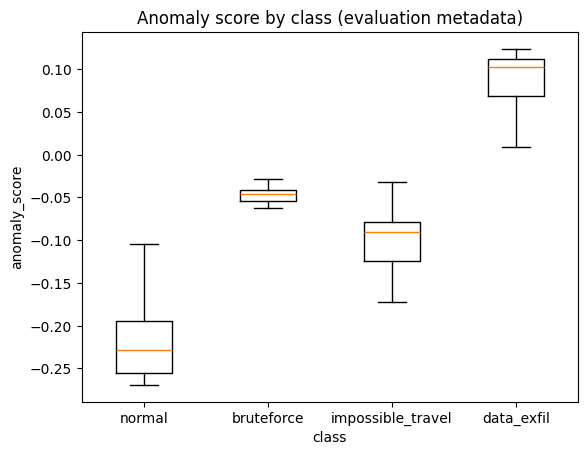

In [36]:
meta2 = meta.copy()
meta2["score"] = scores
meta2["anomaly_type"] = meta2["anomaly_type"].fillna("normal")

# Keep only the main classes for clarity
keep = meta2["anomaly_type"].isin(["normal", "data_exfil", "bruteforce", "impossible_travel"])
m = meta2[keep].copy()

cats = ["normal", "bruteforce", "impossible_travel", "data_exfil"]
data = [m[m["anomaly_type"]==c]["score"].values for c in cats]

plt.figure()
plt.boxplot(data, tick_labels=cats, showfliers=False)
plt.title("Anomaly score by class (evaluation metadata)")
plt.xlabel("class")
plt.ylabel("anomaly_score")
plt.savefig("../reports/anomaly_score_by_class.png")
plt.show()


### Anomaly Score by Class
This boxplot compares anomaly scores across different event classes: normal, bruteforce, impossible_travel, and data_exfil. Each box shows the spread and median score for each class, letting you see which types of events are most anomalous according to your model. This is useful for evaluating how well your model distinguishes between normal and injected anomalies.